<a href="https://colab.research.google.com/github/Raghs-7/Pytorch-tutorial/blob/main/IIS_q2_2024450.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time

torch.manual_seed(42)

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 134MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 51.7MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 63.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.49MB/s]


60000


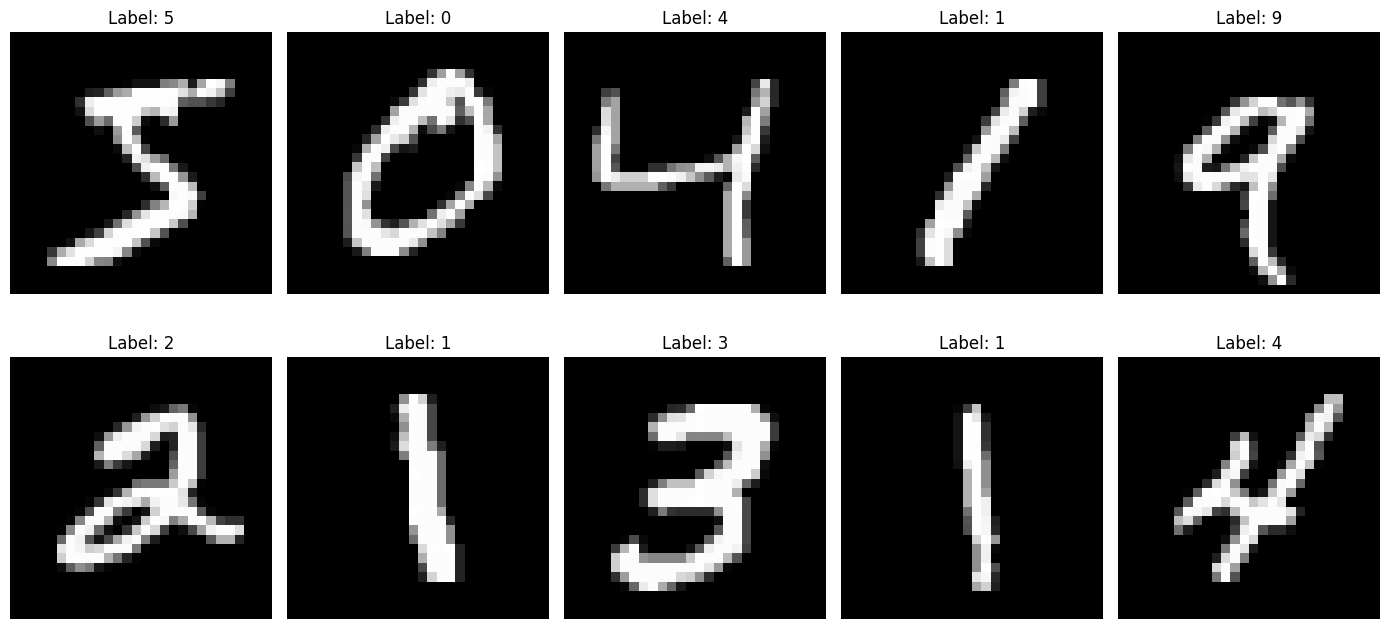

In [3]:
# data analysis and also display the first 10 image of the training data set
def plot_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(14, 7))
    for i in range(len(train_dataset)):
        if i >= 10:
            break
        image, label = train_dataset[i]
        ax = axes[i // 5, i % 5]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

plot_sample_images()


Class Distribution:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


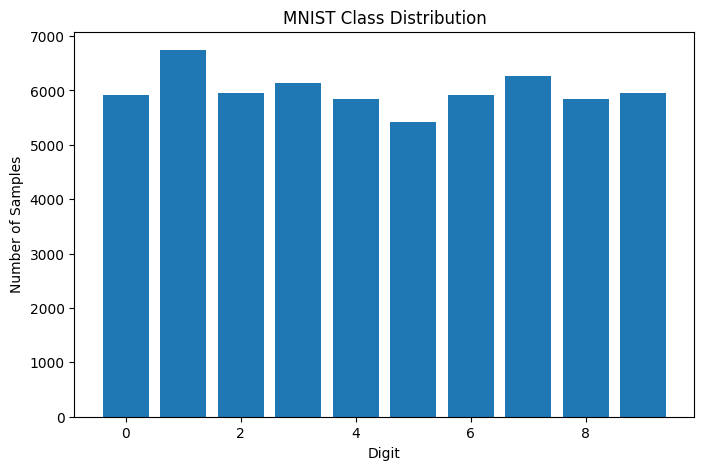

In [4]:
class_counts = {}
for _, label in train_dataset:
    class_counts[label] = class_counts.get(label, 0) + 1

print("Class Distribution:")
for digit in range(10):
    print(f"Digit {digit}: {class_counts[digit]} samples")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Digit')
plt.ylabel('Number of Samples')
plt.title('MNIST Class Distribution')
plt.savefig('class_distribution.png')
plt.show()


In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel()

Epoch 1/5, Train Loss: 0.3519, Train Acc: 89.31%, Val Loss: 0.0539, Val Acc: 98.19%
Time taken :86.10
Epoch 2/5, Train Loss: 0.1198, Train Acc: 96.57%, Val Loss: 0.0493, Val Acc: 98.35%
Time taken :90.34
Epoch 3/5, Train Loss: 0.0853, Train Acc: 97.51%, Val Loss: 0.0394, Val Acc: 98.85%
Time taken :87.74
Epoch 4/5, Train Loss: 0.0684, Train Acc: 97.97%, Val Loss: 0.0355, Val Acc: 98.93%
Time taken :87.49
Epoch 5/5, Train Loss: 0.0574, Train Acc: 98.28%, Val Loss: 0.0320, Val Acc: 99.02%
Time taken :87.86


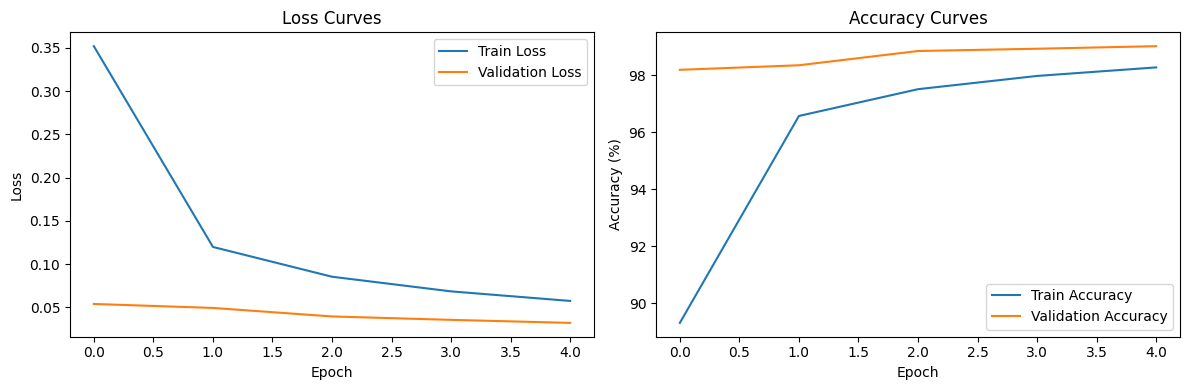

In [6]:
# Task 3:
loss_function = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer

# training looop
num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    print(f'Time taken :{end_time-start_time:.2f}')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


In [7]:
# Task 4: Evaluation and Analysis
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# using skitlearn accuracy_score to find the accuracy of the model and precision and all that
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# making confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# mistakes by the model
misclassified = []
for i in range(len(all_labels)):
    if all_labels[i] != all_preds[i]:
        misclassified.append((all_labels[i], all_preds[i]))

misclassified_dict = {}
for true, pred in misclassified:
    key = (true, pred)
    misclassified_dict[key] = misclassified_dict.get(key, 0) + 1

misclassified_list = []
for key, count in misclassified_dict.items():
    true, pred = key
    misclassified_list.append((true, pred, count))

top_5 = []
for _ in range(min(5, len(misclassified_list))):
    max_count = -1
    max_item = None
    max_idx = -1
    for i in range(len(misclassified_list)):
        true, pred, count = misclassified_list[i]
        if count > max_count:
            max_count = count
            max_item = (true, pred, count)
            max_idx = i
    if max_item != None:
        top_5.append(max_item)
        misclassified_list[max_idx] = (None, None, -1)

print("Most Common errors:")
for true, pred, count in top_5:
    print(f"True: {true}, Predicted: {pred}, Count: {count}")


# imporvements : Train on a larger dataset or include double-digit datasets for better generalization.

torch.save(model.state_dict(), 'mnist_cnn_model.pth')

Test Accuracy: 99.02%
Precision: 0.9902
Recall: 0.9902
F1-Score: 0.9902
Most Common errors:
True: 9, Predicted: 4, Count: 12
True: 7, Predicted: 2, Count: 12
True: 9, Predicted: 5, Count: 6
True: 5, Predicted: 3, Count: 5
True: 0, Predicted: 6, Count: 5
